# 13. Dynamic threshold theo lớp (FlexMatch-lite)

**Mục tiêu:**

Notebook này triển khai và đánh giá phương pháp **Dynamic Threshold** (theo tinh thần FlexMatch) cho bài toán semi-supervised learning với dữ liệu AQI.

**Vấn đề với ngưỡng cố định:**

- Self-training với ngưỡng cố định (τ = 0.9) có xu hướng thiên lệch về các lớp phổ biến (Good, Moderate)
- Các lớp ít gặp (Hazardous, Very_Unhealthy) có recall thấp
- Macro-F1 bị ảnh hưởng do sự mất cân bằng

**Giải pháp - Dynamic Threshold:**

Thay vì sử dụng ngưỡng cố định τ cho tất cả các lớp, ta tính ngưỡng động cho từng lớp c:

$$\tau_c = \max\left(\tau_{\text{base}}, \frac{p_{\text{model}}(c)}{p_{\text{data}}(c)}\right)$$

Trong đó:
- $\tau_{\text{base}}$: Ngưỡng tối thiểu (baseline threshold)
- $p_{\text{model}}(c)$: Tỷ lệ lớp c trong các pseudo-labels hiện tại
- $p_{\text{data}}(c)$: Tỷ lệ lớp c trong labeled data ban đầu

**Ưu điểm:**

- ✅ Tăng ngưỡng cho các lớp phổ biến (tránh over-selection)
- ✅ Giảm ngưỡng cho các lớp hiếm (tăng recall)
- ✅ Cân bằng phân phối lớp trong pseudo-labels
- ✅ Cải thiện Macro-F1

**Các bước thực hiện:**

1. **Cấu hình**: Định nghĩa tham số thử nghiệm (τ_base, max_iter, ...)
2. **Load dữ liệu**: Tải dataset semi-supervised từ file parquet
3. **Triển khai FlexMatch-lite**: Tạo lớp DynamicThresholdSelfTraining
4. **So sánh**: Chạy thử nghiệm với fixed threshold vs dynamic threshold
5. **Trực quan hóa**: Vẽ biểu đồ so sánh hiệu năng và phân tích kết quả

## Bước 1. Cấu hình thử nghiệm

In [20]:
from pathlib import Path
import sys
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Setup paths
PROJECT_ROOT = Path(".").resolve().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print(f"Project Root: {PROJECT_ROOT}")

# Import project modules
from src.semi_supervised_library import SemiDataConfig, AQI_CLASSES

# --- Tham số thử nghiệm ---
TAU_BASE_LIST = [0.9, 0.8, 0.7, 0.6]  
MAX_ITER = 10                       
MAX_NEW_PER_ITER = 500              
SAMPLE_FRAC = 0.2                  
RANDOM_STATE = 42

# --- Cấu hình data ---
CUTOFF = "2017-01-01"  # Ngày chia train/test
TARGET_COL = "aqi_class"

# --- Cấu hình biểu đồ ---
IMAGES_DIR = PROJECT_ROOT / "images"
IMAGES_DIR.mkdir(exist_ok=True)
FONT_CONFIG = {'fontname': 'Arial', 'fontsize': 11}

# Màu sắc theo quy tắc
COLORS = {
    'fixed': '#FF351F',      
    'dynamic': '#1F62FF',    
}

print("\n📊 Cấu hình thử nghiệm:")
print(f"  TAU_BASE_LIST: {TAU_BASE_LIST}")
print(f"  MAX_ITER: {MAX_ITER}")
print(f"  MAX_NEW_PER_ITER: {MAX_NEW_PER_ITER}")
print(f"  SAMPLE_FRAC: {SAMPLE_FRAC}")
print(f"  AQI_CLASSES: {AQI_CLASSES}")

Project Root: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard

📊 Cấu hình thử nghiệm:
  TAU_BASE_LIST: [0.9, 0.8, 0.7, 0.6]
  MAX_ITER: 10
  MAX_NEW_PER_ITER: 500
  SAMPLE_FRAC: 0.2
  AQI_CLASSES: ['Good', 'Moderate', 'Unhealthy_for_Sensitive_Groups', 'Unhealthy', 'Very_Unhealthy', 'Hazardous']


## Bước 2. Tải dữ liệu và chuẩn bị dữ liệu

In [21]:
from sklearn.preprocessing import LabelEncoder

print("Loading data...")
semi_dataset_path = PROJECT_ROOT / "data" / "processed" / "02_dataset_for_semi.parquet"
df_semi = pd.read_parquet(semi_dataset_path)

# Lấy mẫu để chạy nhanh
df_sample = df_semi.sample(frac=SAMPLE_FRAC, random_state=RANDOM_STATE)
print(f"Sample size: {len(df_sample)} rows")

# Load feature list
feature_list_path = PROJECT_ROOT / "data" / "processed" / "03_feature_list.csv"
df_features = pd.read_csv(feature_list_path)
numeric_features = [f for f in df_features["feature"] if f not in ['wd', 'station']]

# Tách labeled và unlabeled
df_labeled = df_sample[df_sample['is_labeled']].copy()
df_unlabeled = df_sample[~df_sample['is_labeled']].copy()

print(f"Labeled: {len(df_labeled)}, Unlabeled: {len(df_unlabeled)}")

# --- Mã hóa nhãn (Label Encoding) ---
# Quan trọng: Chuyển nhãn dạng chữ ('Good', 'Moderate') sang số (0, 1)
# Encoder phải được fit trên TẤT CẢ các lớp có thể có
label_encoder = LabelEncoder()
label_encoder.fit(AQI_CLASSES) # Fit trên list đầy đủ các lớp

# Áp dụng encoder cho cột target
df_labeled[TARGET_COL] = label_encoder.transform(df_labeled[TARGET_COL])
print("\n✅ Nhãn đã được mã hóa sang dạng số.")

# Kiểm tra phân phối lớp trong labeled data
print(f"\n📊 Phân phối lớp trong labeled data:")
class_dist = df_labeled[TARGET_COL].value_counts().sort_index() # sort_index để khớp với encoder
print(class_dist)
print(f"Mapping: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")


# Tách train/test từ labeled data (time-based split)
df_labeled['datetime'] = pd.to_datetime(df_labeled['datetime'])
train_mask = df_labeled['datetime'] < CUTOFF
df_train_labeled = df_labeled[train_mask].copy()
df_test = df_labeled[~train_mask].copy()

print(f"\nTrain (labeled): {len(df_train_labeled)}, Test: {len(df_test)}")

# Chuẩn bị ma trận X, y
X_train_lab = df_train_labeled[numeric_features]
y_train_lab = df_train_labeled[TARGET_COL]

X_test = df_test[numeric_features]
y_test = df_test[TARGET_COL]

# Xử lý missing values
imputer = SimpleImputer(strategy='mean')
X_train_lab_imp = imputer.fit_transform(X_train_lab)
X_test_imp = imputer.transform(X_test)

# Chuẩn hóa
scaler = StandardScaler()
X_train_lab_scaled = scaler.fit_transform(X_train_lab_imp)
X_test_scaled = scaler.transform(X_test_imp)

# Lưu unlabeled data để sử dụng sau
X_unlabeled = df_unlabeled[numeric_features]
X_unlabeled_imp = imputer.transform(X_unlabeled)
X_unlabeled_scaled = scaler.transform(X_unlabeled_imp)

print(f"\n✅ Dữ liệu đã được chuẩn bị:")
print(f"  X_train_lab: {X_train_lab_scaled.shape}")
print(f"  X_test: {X_test_scaled.shape}")
print(f"  X_unlabeled: {X_unlabeled_scaled.shape}")


Loading data...
Sample size: 84154 rows
Labeled: 7356, Unlabeled: 76798

✅ Nhãn đã được mã hóa sang dạng số.

📊 Phân phối lớp trong labeled data:
aqi_class
0     335
1     548
2    2054
3    2270
4    1095
5    1054
Name: count, dtype: int64
Mapping: {np.str_('Good'): np.int64(0), np.str_('Hazardous'): np.int64(1), np.str_('Moderate'): np.int64(2), np.str_('Unhealthy'): np.int64(3), np.str_('Unhealthy_for_Sensitive_Groups'): np.int64(4), np.str_('Very_Unhealthy'): np.int64(5)}

Train (labeled): 4000, Test: 3356

✅ Dữ liệu đã được chuẩn bị:
  X_train_lab: (4000, 49)
  X_test: (3356, 49)
  X_unlabeled: (76798, 49)


## Bước 3. Triển khai thuật toán DynamicThresholdSelfTraining

In [22]:
class DynamicThresholdSelfTraining:
    """
    Self-training với dynamic threshold theo lớp (FlexMatch-lite)
    
    Công thức: tau_c = max(tau_base, p_model(c) / p_data(c))
    """
    
    def __init__(self, base_model, tau_base=0.7, max_iter=10, 
                 max_new_per_iter=100, use_dynamic=True, verbose=True):
        """
        Parameters:
        -----------
        base_model : sklearn classifier
            Mô hình base (e.g., HistGradientBoostingClassifier)
        tau_base : float
            Ngưỡng tối thiểu (baseline threshold)
        max_iter : int
            Số vòng lặp tối đa
        max_new_per_iter : int
            Số pseudo-labels tối đa mỗi vòng
        use_dynamic : bool
            True = dynamic threshold, False = fixed threshold
        verbose : bool
            In thông tin chi tiết
        """
        self.base_model = base_model
        self.tau_base = tau_base
        self.max_iter = max_iter
        self.max_new_per_iter = max_new_per_iter
        self.use_dynamic = use_dynamic
        self.verbose = verbose
        
        self.model_ = None
        self.classes_ = None
        self.history_ = []  # Lưu lịch sử training
        
        # Thêm thuộc tính để lưu chỉ số của pseudo-labels được chọn
        self.selected_indices_history_ = []

    def fit(self, X_labeled, y_labeled, X_unlabeled):
        """
        Huấn luyện mô hình với self-training
        
        Parameters:
        -----------
        X_labeled : array-like, shape (n_labeled, n_features)
            Dữ liệu labeled
        y_labeled : array-like, shape (n_labeled,)
            Nhãn của dữ liệu labeled
        X_unlabeled : array-like, shape (n_unlabeled, n_features)
            Dữ liệu unlabeled
        """
        # Convert to numpy arrays and get original indices
        X_labeled = np.array(X_labeled)
        y_labeled = np.array(y_labeled)
        X_unlabeled_orig = X_unlabeled.copy() # Keep original to get indices
        X_unlabeled = np.array(X_unlabeled)
        
        # Lấy danh sách các lớp
        self.classes_ = np.unique(y_labeled)
        
        # Tính phân phối lớp ban đầu (p_data)
        p_data = self._compute_class_distribution(y_labeled)
        
        # Khởi tạo training set
        X_train = X_labeled.copy()
        y_train = y_labeled.copy()
        
        # Pool unlabeled
        unlabeled_indices = np.arange(len(X_unlabeled))

        if self.verbose:
            print(f"\n🚀 Bắt đầu {'Dynamic' if self.use_dynamic else 'Fixed'} Threshold Self-Training")
            print(f"  Initial labeled: {len(X_labeled)}")
            print(f"  Unlabeled pool: {len(unlabeled_indices)}")
            print(f"  tau_base: {self.tau_base}")
            print(f"  p_data: {dict(zip(self.classes_, p_data.round(3)))}")
        
        # Self-training loop
        for iteration in range(self.max_iter):
            if len(unlabeled_indices) == 0:
                if self.verbose:
                    print(f"  ⚠️ Iteration {iteration}: No more unlabeled data")
                break
            
            # Huấn luyện mô hình trên tập hiện tại
            from sklearn.base import clone
            self.model_ = clone(self.base_model)
            self.model_.fit(X_train, y_train)
            
            # Dự đoán trên pool unlabeled
            X_pool = X_unlabeled[unlabeled_indices]
            proba = self.model_.predict_proba(X_pool)
            y_pred = self.model_.predict(X_pool)
            
            # Tính thresholds
            if self.use_dynamic:
                p_model = self._compute_class_distribution(y_pred)
                thresholds = np.maximum(self.tau_base, p_data / (p_model + 1e-6))
            else:
                thresholds = np.full(len(self.classes_), self.tau_base)

            # Chọn pseudo-labels
            max_proba = proba.max(axis=1)
            
            # Lấy threshold tương ứng cho mỗi sample
            sample_thresholds = thresholds[y_pred.astype(int)]
            
            # Tìm các chỉ số của samples đủ điều kiện
            confident_mask = max_proba >= sample_thresholds
            confident_indices_in_pool = np.where(confident_mask)[0]
            
            # Giới hạn số lượng pseudo-labels mới
            if len(confident_indices_in_pool) > self.max_new_per_iter:
                sorted_indices = confident_indices_in_pool[np.argsort(-max_proba[confident_indices_in_pool])]
                new_indices_in_pool = sorted_indices[:self.max_new_per_iter]
            else:
                new_indices_in_pool = confident_indices_in_pool
            
            # Lấy chỉ số gốc trong X_unlabeled
            new_indices_orig = unlabeled_indices[new_indices_in_pool]
            
            # --- Ghi lại lịch sử các chỉ số được chọn ---
            self.selected_indices_history_.append(set(new_indices_orig))

            if self.verbose:
                print(f"  Iter {iteration}: Pool={len(unlabeled_indices)}, Found={len(confident_indices_in_pool)}, Added={len(new_indices_in_pool)}")
            
            if len(new_indices_in_pool) == 0:
                if self.verbose:
                    print("  🛑 Dừng vì không có pseudo-label mới.")
                break

            # Thêm pseudo-labels vào training set
            X_train = np.vstack([X_train, X_pool[new_indices_in_pool]])
            y_train = np.concatenate([y_train, y_pred[new_indices_in_pool]])

            # Xóa khỏi pool
            unlabeled_indices = np.setdiff1d(unlabeled_indices, new_indices_orig)
            
            # Lưu history
            self.history_.append({
                "iter": iteration,
                "new_pseudo": len(new_indices_in_pool),
                "unlabeled_pool": len(unlabeled_indices),
                "thresholds": dict(zip(self.classes_, thresholds.round(3)))
            })

        return self

    def predict(self, X):
        return self.model_.predict(X)
        
    def _compute_class_distribution(self, y):
        counts = np.bincount(y.astype(int), minlength=len(self.classes_))
        return counts / (counts.sum() + 1e-6)


## Bước 4. Chạy thử nghiệm

In [23]:
results = []
# --- Thêm một dictionary để lưu trữ các tập hợp chỉ số được chọn ---
selected_indices_log = {}

for use_dynamic in [False, True]:
    method_name = "Dynamic" if use_dynamic else "Fixed"
    
    for tau_base in TAU_BASE_LIST:
        experiment_seed = RANDOM_STATE + int(tau_base * 100)
        
        # Tạo base model với seed thay đổi nhẹ để đảm bảo tính nhất quán
        base_model = HistGradientBoostingClassifier()
        
        # Khởi tạo mô hình self-training
        st_model = DynamicThresholdSelfTraining(
            base_model=base_model,
            tau_base=tau_base,
            max_iter=MAX_ITER,
            max_new_per_iter=MAX_NEW_PER_ITER,
            use_dynamic=use_dynamic,
            verbose=False
        )
        
        print(f"🔬 Running: {method_name} with tau_base = {tau_base}...")
        
        # Huấn luyện
        st_model.fit(X_train_lab_scaled, y_train_lab.values, X_unlabeled_scaled)
        
        # --- Lưu lại tập hợp chỉ số của vòng lặp ĐẦU TIÊN ---
        run_key = f"{method_name}_tau{tau_base}"
        if st_model.selected_indices_history_:
            selected_indices_log[run_key] = st_model.selected_indices_history_[0]
        else:
            selected_indices_log[run_key] = set()

        # Đánh giá
        y_pred = st_model.predict(X_test_scaled)
        
        f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
        f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        accuracy = accuracy_score(y_test, y_pred)
        
        # Lấy report chi tiết
        # Thêm `labels` để đảm bảo report luôn có đủ tất cả các lớp
        report_labels = np.arange(len(AQI_CLASSES))
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0, labels=report_labels)
        
        result = {
            "method": method_name,
            "tau_base": tau_base,
            "f1_macro": f1_macro,
            "f1_weighted": f1_weighted,
            "accuracy": accuracy
        }
        
        # Thêm recall và f1 cho từng lớp
        for i, class_name in enumerate(AQI_CLASSES):
            # SỬA LỖI: Dùng str(i) thay vì str(float(i)) để lấy key
            class_report = report.get(str(i), {'recall': 0, 'f1-score': 0})
            result[f'recall_{class_name}'] = class_report['recall']
            result[f'f1_{class_name}'] = class_report['f1-score']
            
        results.append(result)

print("\n✅ Hoàn thành tất cả các thử nghiệm!")


🔬 Running: Fixed with tau_base = 0.9...
🔬 Running: Fixed with tau_base = 0.8...
🔬 Running: Fixed with tau_base = 0.7...
🔬 Running: Fixed with tau_base = 0.6...
🔬 Running: Dynamic with tau_base = 0.9...
🔬 Running: Dynamic with tau_base = 0.8...
🔬 Running: Dynamic with tau_base = 0.7...
🔬 Running: Dynamic with tau_base = 0.6...

✅ Hoàn thành tất cả các thử nghiệm!


## Bước 5. Tổng hợp và trực quan hóa kết quả

📊 Bảng tổng hợp kết quả:


,method,tau_base,f1_macro,f1_weighted,accuracy
0,Fixed,0.9,0.472601,0.549216,0.578665
1,Fixed,0.8,0.472601,0.549216,0.578665
2,Fixed,0.7,0.472601,0.549216,0.578665
3,Fixed,0.6,0.472601,0.549216,0.578665
4,Dynamic,0.9,0.441370,0.529638,0.571216
5,Dynamic,0.8,0.441370,0.529638,0.571216
6,Dynamic,0.7,0.441370,0.529638,0.571216
7,Dynamic,0.6,0.441370,0.529638,0.571216



💾 Saved: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\images\13_01_f1_macro_comparison.png


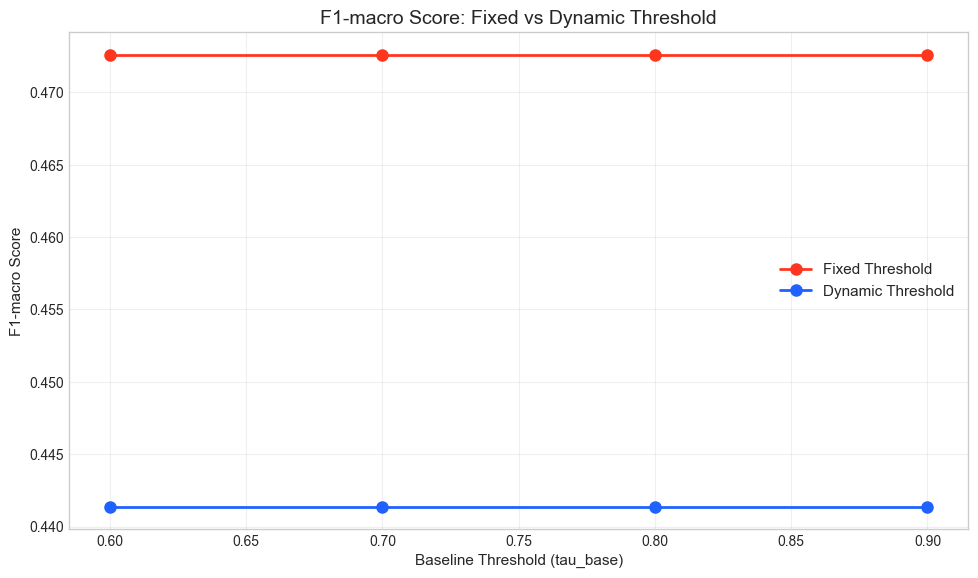

💾 Saved: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\images\13_02_f1_per_class.png


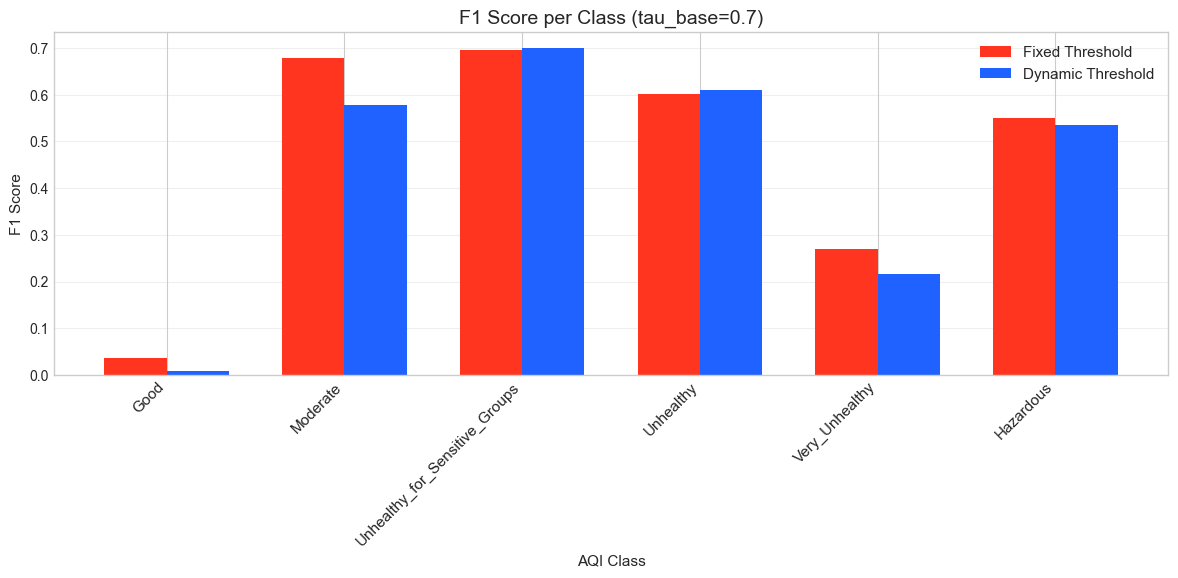

💾 Saved: E:\dnu.khmt.1701.1771040029@gmail.com\AirGuard\images\13_03_recall_rare_classes.png


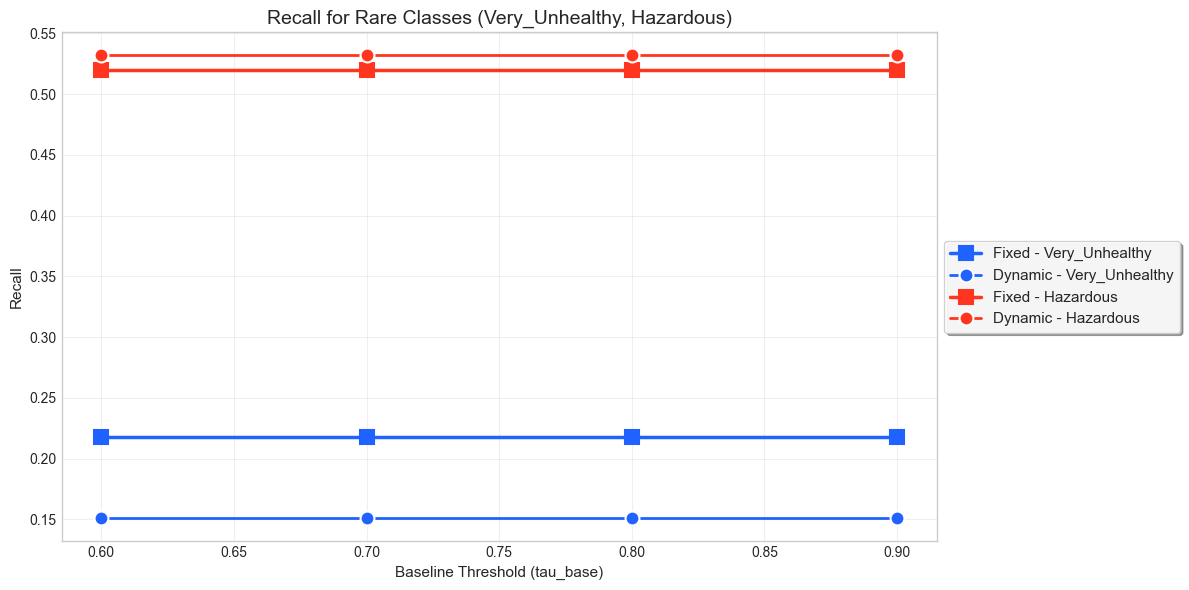

In [25]:
df_results = pd.DataFrame(results)

# Hiển thị bảng kết quả tổng quan
print("📊 Bảng tổng hợp kết quả:")
display(df_results[['method', 'tau_base', 'f1_macro', 'f1_weighted', 'accuracy']].sort_values('f1_macro', ascending=False))

# --- Biểu đồ 1: So sánh F1-macro theo tau_base ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

for method in ['Fixed', 'Dynamic']:
    df_method = df_results[df_results['method'] == method]
    ax.plot(
        df_method['tau_base'], 
        df_method['f1_macro'], 
        marker='o', 
        linewidth=2, 
        markersize=8,
        label=f"{method} Threshold",
        color=COLORS['dynamic' if method == 'Dynamic' else 'fixed']
    )

ax.set_xlabel('Baseline Threshold (tau_base)', **FONT_CONFIG)
ax.set_ylabel('F1-macro Score', **FONT_CONFIG)
title_font = FONT_CONFIG.copy()
title_font['fontsize'] = 14
ax.set_title('F1-macro Score: Fixed vs Dynamic Threshold', **title_font)
ax.legend(prop={'family': 'Arial', 'size': 11})
ax.grid(True, alpha=0.3)

plt.tight_layout(pad=1.5)
save_path = IMAGES_DIR / "13_01_f1_macro_comparison.png"
plt.savefig(save_path, dpi=300)
print(f"\n💾 Saved: {save_path}")
plt.show()

# --- Biểu đồ 2: F1 per class (tau_base=0.7) ---
fig, ax = plt.subplots(figsize=(12, 6))

# Chọn tau_base = 0.7 để so sánh
df_compare = df_results[df_results['tau_base'] == 0.7]

x = np.arange(len(AQI_CLASSES))
width = 0.35

for i, method in enumerate(['Fixed', 'Dynamic']):
    row = df_compare[df_compare['method'] == method].iloc[0]
    f1_scores = [row.get(f'f1_{c}', 0) for c in AQI_CLASSES]
    
    ax.bar(
        x + i * width, 
        f1_scores, 
        width, 
        label=f"{method} Threshold",
        color=COLORS['dynamic' if method == 'Dynamic' else 'fixed']
    )

ax.set_xlabel('AQI Class', **FONT_CONFIG)
ax.set_ylabel('F1 Score', **FONT_CONFIG)
title_font = FONT_CONFIG.copy()
title_font['fontsize'] = 14
ax.set_title('F1 Score per Class (tau_base=0.7)', **title_font)
ax.set_xticks(x + width / 2)
ax.set_xticklabels(AQI_CLASSES, rotation=45, ha='right', **FONT_CONFIG)
ax.legend(prop={'family': 'Arial', 'size': 11})
ax.grid(True, axis='y', alpha=0.3)

plt.tight_layout(pad=1.5)
save_path = IMAGES_DIR / "13_02_f1_per_class.png"
plt.savefig(save_path, dpi=300)
print(f"💾 Saved: {save_path}")
plt.show()

# --- Biểu đồ 3: Recall cho các lớp hiếm (Hazardous, Very_Unhealthy) ---
fig, ax = plt.subplots(figsize=(12, 6))

rare_classes = ['Very_Unhealthy', 'Hazardous']

# Định nghĩa màu và marker riêng cho từng tổ hợp
configs = {
    ('Fixed', 'Very_Unhealthy'): {'color': '#1F62FF', 'marker': 's', 'linestyle': '-', 'linewidth': 2.5},
    ('Dynamic', 'Very_Unhealthy'): {'color': '#1F62FF', 'marker': 'o', 'linestyle': '-', 'linewidth': 2},
    ('Fixed', 'Hazardous'): {'color': '#FF351F', 'marker': 's', 'linestyle': '-', 'linewidth': 2.5},
    ('Dynamic', 'Hazardous'): {'color': '#FF351F', 'marker': 'o', 'linestyle': '-', 'linewidth': 2},
}

for c in rare_classes:
    for method in ['Fixed', 'Dynamic']:
        df_method = df_results[df_results['method'] == method]
        recalls = df_method[f'recall_{c}'].values
        
        cfg = configs[(method, c)]
        ax.plot(
            df_method['tau_base'], 
            recalls, 
            marker=cfg['marker'], 
            linewidth=cfg['linewidth'], 
            markersize=10,
            label=f"{method} - {c}",
            linestyle=cfg['linestyle'],
            color=cfg['color'],
            markeredgewidth=1.5,
            markeredgecolor='white' if method == 'Dynamic' else cfg['color']
        )

ax.set_xlabel('Baseline Threshold (tau_base)', **FONT_CONFIG)
ax.set_ylabel('Recall', **FONT_CONFIG)
title_font = FONT_CONFIG.copy()
title_font['fontsize'] = 14
ax.set_title('Recall for Rare Classes (Very_Unhealthy, Hazardous)', **title_font)

# Tùy chỉnh legend để dễ hiểu hơn
legend = ax.legend(
    prop={'family': 'Arial', 'size': 11}, 
    loc='center left', 
    bbox_to_anchor=(1, 0.5),
    frameon=True,
    fancybox=True,
    shadow=True
)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
save_path = IMAGES_DIR / "13_03_recall_rare_classes.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"💾 Saved: {save_path}")
plt.show()
